In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import itertools

from tqdm.notebook import tqdm, trange

import torch
from torch.utils.data import DataLoader
nn = torch.nn
import torch.nn.functional as F

import nmastandard as nmas

#@title import, set defaults and define variables
from matplotlib import rcParams 
from matplotlib import pyplot as plt

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import numpy as np
import seaborn as sns

# Load Steinmetz data

In [2]:
#@title Data retrieval and loading
import os, urllib.request


#url
urlfiles = {
    'agvxh': 'steinmetz_part1.npz',
    'uv3mw': 'steinmetz_part2.npz',
    'ehmw2': 'steinmetz_part3.npz'}

alldat = []
# get spike data
for aurl in urlfiles:
  file = urlfiles[aurl]
  if not os.path.exists(file):
    urllib.request.urlretrieve('https://osf.io/{}/download'.format(aurl),
                                                         filename=file)
  alldat = np.hstack((alldat,np.load(file, allow_pickle=True)['dat']))
  print('Loaded: {}'.format(file))
subject = 11
dat = alldat[subject]



Loaded: steinmetz_part1.npz
Loaded: steinmetz_part2.npz
Loaded: steinmetz_part3.npz


Utility Functions

In [3]:
#trials are all 2500ms, with 500 ms ITI and stim onset at 500 ms or 50 bins
#(https://neurostars.org/t/steinmetz-et-al-2019-dataset-questions/14539/8)
#input e.g:  dat['response_time']

def timePoints2Bins(timePoints):
    x=timePoints*100 #seconds to ms in 10 ms bins
    bins=np.floor(x)  
    return(bins)

In [4]:
#spike data: dat['spks']
#spike data is a 3D matrix: neurons x trials x time
spikes=dat['spks']
_,trialLen,_=spikes.shape

#for cutting spikes from stim onset to 300 ms
stimDuration=spikes[:,:,50:80]

#for a single session, input the time bin of the reference timepoint (e.g. response time),
#plus or minus duration in ms (e.g. 300ms)
#if method = 'add','minus'

def cutSpikeTimes(referenceTime_bin, spikes, method, msDuration):
    msIdx=int(msDuration/10)
    #initialize new 3D matrix
    newSpikes=np.zeros((spikes.shape[0],spikes.shape[1], int(msIdx)))
    
    if np.min(referenceTime_bin)<msIdx:
            raise IndexError('index falls outside of the dataframe')
    
    for iTrial,x in enumerate(referenceTime_bin):
        if method=='add':
            newSpikes[:,iTrial,:]=spikes[:,iTrial,int(x):int(x)+msIdx]
        elif method=='minus':
            newSpikes[:,iTrial,:]=spikes[:,iTrial,int(x)-msIdx:int(x)]
    return(newSpikes)
            

In [5]:
referenceTime_bin=timePoints2Bins(dat['response_time'])

#450 ms before response time:responseTime
#cutSpikeTimes(referenceTime_bin, spikes, 'minus', 450)

In [6]:
def pad_along_axis(array: np.ndarray, target_length: int, axis: int = 0):

    pad_size = target_length - array.shape[axis]

    if pad_size <= 0:
        return array

    npad = [(0, 0)] * array.ndim
    npad[axis] = (0, pad_size)

    return np.pad(array, pad_width=npad, mode='constant', constant_values=0)

In [7]:
def concatSpikesPerSession(sessionIdx):
    alldatTmp=alldat.copy()
    brainRegionIdx=np.concatenate([alldatTmp[x]['brain_area'] for x in sessionIdx])
    maxTrials=np.max([alldatTmp[x]['spks'].shape[1] for x in sessionIdx])

    spikesAllSessions=[]
    for num, i in enumerate(sessionIdx):
        #alldatTmp[i]['spks'] = pad_along_axis(alldatTmp[i]['spks'], 300, axis=1)
        if num==0:
            stacked=pad_along_axis(alldatTmp[i]['spks'], 300, axis=1)
        else:
            stacked=np.vstack((stacked,pad_along_axis(alldatTmp[i]['spks'], 300, axis=1)))
        
    return(stacked, brainRegionIdx)
        #print(alldatTmp[i]['spks'].shape)
        #print(stacked.shape)
        

In [8]:
mouseList=[ alldat[x]['mouse_name'] for x in range(len(alldat))]

#index dataframe by mouse
indices = [i for i, elem in enumerate(mouseList) if 'Forssmann' in elem]

stackedForsman, brainRegion_Forsman=concatSpikesPerSession(indices)

In [9]:
stackedForsman.shape

(4599, 300, 250)

# Load toy neural data

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
# set the seed
np.random.seed(42)

# 100 trials is typical of neural data
ntrials = 100

# we simulate 200 neurons
NN = 400

# we will pretend like every "bin" is 10ms, so the trial length is 2500ms
NT = 250

# let's use 10 latent components
ncomp = 10

# this is the recurrent dynamics matrix, which we made diagonal for simplicity
# values have to be smaller than 1 for stability
A0 =  np.diag(.8 + .2 * np.random.rand(ncomp,))

# this is the projection matrix from components to neurons
C0 = .025 * np.random.randn(ncomp, NN)

# We generate the dynamics of the low-d system. We initialize the latent state.

# start by initializing the latents
y       = 2 * np.random.randn(ncomp)
latents = np.zeros((NT, ntrials, ncomp))
# we run the dynamics forward and add noise (or "innovations") at each timestep
for t in range(NT):
  y = y @ A0 +  np.random.randn(ntrials, ncomp)
  latents[t] = y

# we now project the latents to the neuron space and threshold to generate firing rates
rates = np.maximum(0, latents @ C0)

# now we draw poisson counts to simulate the number of spikes a neuron fires randomly
xN = np.random.poisson(rates)

# Autoencoder

In [12]:
# %load nmastandard.py

# for DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

# inform the user if the notebook uses GPU or CPU.

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

Random seed 2021 has been set.


tensor(0.)



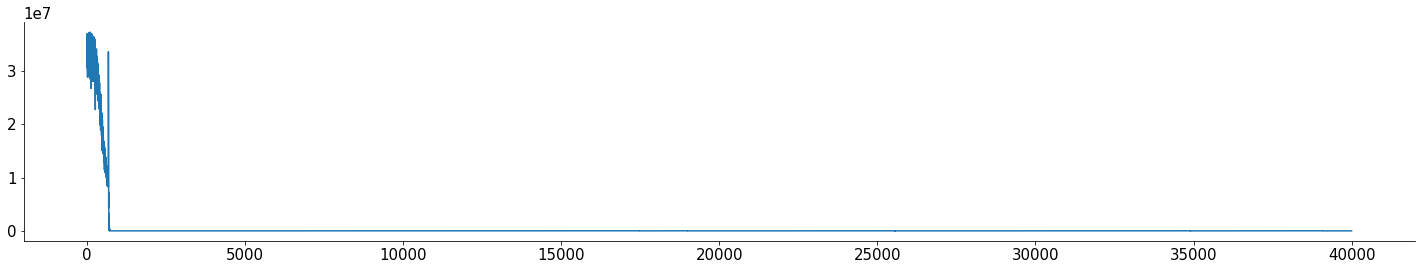

In [13]:
# %load autoencoder.py

class AE(nn.Module):
  def __init__(self, in_dim, latent_dim, enc_lst, dec_lst):
    """
    Initialize AutoEncoder
    ---
    Parameters:
    * in_dim : Number of input dimensions
    * latent_dim : Size of latent space
    * enc_lst : List of number of hidden nodes at each encoder layer
    * dec_lst : List of number of hidden nodes at each decoder layer
    """

    super(AE, self).__init__()

    self.in_dim = in_dim
    self.out_dim = in_dim

    # Create Encoder Model
    layers_a = [[nn.Linear(in_dim, enc_lst[0], bias=True), nn.ReLU()]]
    layers_a += [[nn.Linear(enc_lst[idim], enc_lst[idim+1], bias=True), nn.ReLU()] for idim in range(len(enc_lst)-1)]
    layers_a += [[nn.Linear(enc_lst[-1], latent_dim, bias=True)]]
    enc_layers = []
    for layer in layers_a:
      enc_layers += layer
    self.enc_model = nn.Sequential(*enc_layers)


    # Create Decoder Model
    layers_a = [[nn.Linear(latent_dim, dec_lst[0], bias=True), nn.ReLU()]]
    layers_a += [[nn.Linear(dec_lst[idim], dec_lst[idim+1], bias=True), nn.ReLU()] for idim in range(len(dec_lst)-1)]
    layers_a += [[nn.Linear(dec_lst[-1], in_dim, bias=True)]]
    dec_layers = []
    for layer in layers_a:
      dec_layers += layer
    self.dec_model = nn.Sequential(*dec_layers)

  def encode(self, x):
    '''
    Enocdes x into the latent space
    ---
    Parameters:
    * x (torch.tensor) : The dataset to encode (size: num_examples x in_dim)

    Returns:
    * l (torch.tensor) : Projection into the latent space of original data (size: num_examples x latent_dim)
    '''
    return self.enc_model(x)

  def decode(self, l):
    '''
    Decode l from the latent space into the initial dataset
    ---
    Parameters:
    * l (torch.tensor) : The encoded latent space representation (size: num_examples x latent_dim)

    Returns:
    * x (torch.tensor) : Approximation of the original dataset encoded (size: num_examples x in_dim)
    '''
    return self.dec_model(l)

  def forward(self, x):
    '''
    Feed raw dataset through encoder -> decoder model in order to generate overall approximation from latent space
    ---
    Parameters:
    * x (torch.tensor) : The dataset to encode (size: num_examples x in_dim)

    Returns:
    * x (torch.tensor) : Approximation of the original dataset from the encoded latent space (size: num_examples x in_dim)
    '''
    flat_x = x.view(x.size(0), -1)
    h = self.encode(flat_x)
    return self.decode(h).view(x.size())

def train_autoencoder(autoencoder, dataset, device, epochs=20, batch_size=250,
                      seed=0):
  '''
  Train the provided "autoencoder" model on the provided tensor dataset.
  ---
  Parameters:
  * autoencoder (AE) : AE model to train
  * dataset (torch.tensor) : The dataset to encode (size: num_examples x in_dim)
  * device (str) : Device to use for training ('cuda' or 'cpu')
  * epochs (int) : Number of iterations through the entire dataset on which to train
  * batch_size (int) : Number of examples in randomly sampled batches to pass through the model
  * seed (int) : Random seed to use for the model

  Returns:
  * mse_loss (torch.tensor) : List of Mean Squared Error losses by training timestep
  '''

  autoencoder.to(DEVICE)
  optim = torch.optim.Adam(autoencoder.parameters(),
                           lr=1e-2,
                           #weight_decay=1e-5
                           )
  loss_fn = nn.MSELoss()
  g_seed = torch.Generator()
  g_seed.manual_seed(seed)
  loader = DataLoader(dataset,
                      batch_size=batch_size,
                      shuffle=True,
                      pin_memory=True,
                      num_workers=2,
                      worker_init_fn=nmas.seed_worker,
                      generator=g_seed)

  mse_loss = torch.zeros(epochs * len(dataset) // batch_size, device=device)
  i = 0
  for epoch in trange(epochs, desc='Epoch'):
    # print(len(list(itertools.islice(loader, 1))))
    for im_batch in loader:
      im_batch = im_batch.to(device)
      optim.zero_grad()
      reconstruction = autoencoder(im_batch)
      # write the loss calculation
      loss = loss_fn(reconstruction.view(batch_size, -1),
                    target=im_batch.view(batch_size, -1))
      loss.backward()
      optim.step()

      mse_loss[i] = loss.detach()
      i += 1
    
    if epoch % 100 == 0:
      print(mse_loss[i])
  
  # After training completes, make sure the model is on CPU so we can easily
  # do more visualizations and demos.
  autoencoder.to('cpu')
  return mse_loss.cpu()

if __name__ == '__main__':
    SEED = 2021
    nmas.set_seed(seed=SEED)
    DEVICE = nmas.set_device()

    
    x_a = np.random.choice(10000, size=100000)
    tmp = np.tile(np.arange(-1,2), (x_a.shape[0],1))
    x = np.tile(x_a.reshape(-1,1), [1, 3]) + tmp

    tmp = torch.tensor(tmp).float()
    x = torch.tensor(x).float()

    vae = AE(x.size(-1), 1, [5], [5])
    loss = train_autoencoder(vae, x, DEVICE, epochs=100, batch_size=250, seed=0)

    plt.plot(loss)

In [22]:
xN

array([[[0, 0, 0, ..., 2, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 3, 0, ..., 0, 0, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [ ]:
#Here, lets test all trials x all time steps for all neurons
#(i.e., lets train it on everything and see what happens)

In [17]:
test_xN=xN.reshape(-1, xN.shape[-1])

#test_xN=xN[50,:,:]

In [18]:
#num time steps x trials, numNeurons
xN.shape

(250, 100, 400)

In [19]:
test_xN.sum(axis=1)

array([29, 32, 21, ..., 32, 23, 31])

In [20]:
test_xN=torch.tensor(test_xN).float()

tensor(0.)



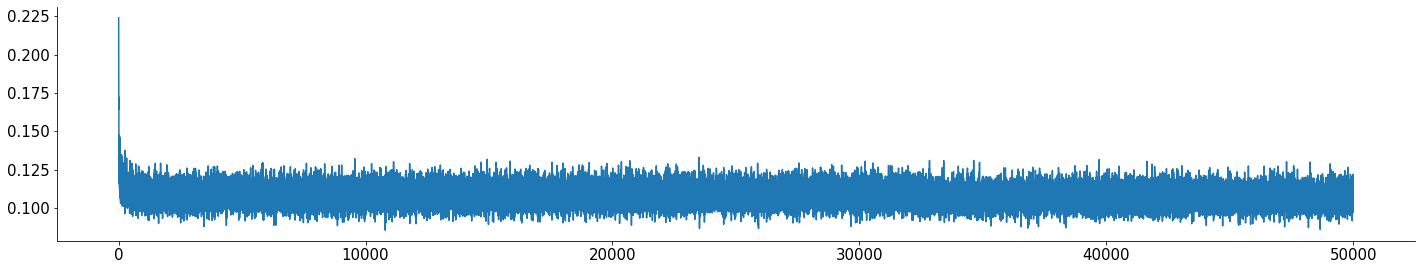

In [21]:
vae = AE(test_xN.size(1), 2, [5], [5])
loss = train_autoencoder(vae, test_xN, DEVICE, epochs=100, batch_size=50, seed=0)

plt.plot(loss)

In [45]:
pltTestXN=xN[:,5,:]

In [49]:
pltTestXN.shape

torch.Size([250, 400])

In [46]:
pltTestXN=torch.tensor(pltTestXN).float()

In [47]:
plot_testxN=vae.encode(pltTestXN).detach().numpy()

In [50]:
plot_testxN.shape

(250, 2)

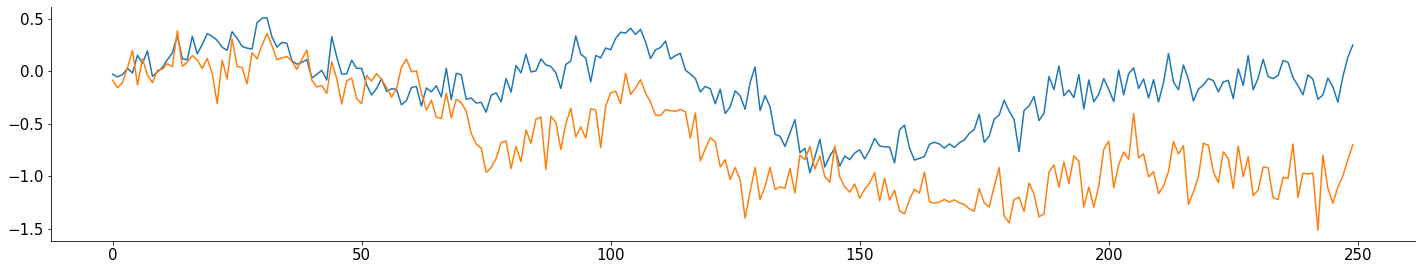

In [48]:
plt.plot(plot_testxN)